# Imports

In [15]:
import numpy as np
import pandas as pd
import re
import nltk
import math
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold, KFold, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import scikitplot as skplt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Loading Data

In [2]:
data = pd.read_csv('Tweets.csv')
data = data.drop(data.query("airline_sentiment_confidence<0.6").index, axis = 0).reset_index(drop=True)
tweets_df = pd.concat([data['text'], data['airline_sentiment']], axis=1) 
print(tweets_df)

                                                    text airline_sentiment
0                    @VirginAmerica What @dhepburn said.           neutral
1      @VirginAmerica I didn't today... Must mean I n...           neutral
2      @VirginAmerica it's really aggressive to blast...          negative
3      @VirginAmerica and it's a really big bad thing...          negative
4      @VirginAmerica seriously would pay $30 a fligh...          negative
...                                                  ...               ...
14397         @AmericanAir right on cue with the delays👌          negative
14398  @AmericanAir leaving over 20 minutes Late Flig...          negative
14399  @AmericanAir Please bring American Airlines to...           neutral
14400  @AmericanAir you have my money, you change my ...          negative
14401  @AmericanAir we have 8 ppl so we need 2 know h...           neutral

[14402 rows x 2 columns]


# Preprocessing

In [3]:
#Loading stopwords

stop = set(stopwords.words("english"))
stopadd = set()

for word in stop:
    stopadd.add(re.sub(r'[^a-z0-9\s]', '', word))  # Adding incomplete stopwords to stopwords set

stop = stop.union(stopadd)
stop = stop.union({'dm', 'u', 'im'}) 

In [4]:
#Turns sentiment into numerical values

tweets_df['airline_sentiment'] = tweets_df['airline_sentiment'].apply(
    lambda text: 0 if text=="negative" else 1 if text=="neutral" else 2 
    )

print(tweets_df)

                                                    text  airline_sentiment
0                    @VirginAmerica What @dhepburn said.                  1
1      @VirginAmerica I didn't today... Must mean I n...                  1
2      @VirginAmerica it's really aggressive to blast...                  0
3      @VirginAmerica and it's a really big bad thing...                  0
4      @VirginAmerica seriously would pay $30 a fligh...                  0
...                                                  ...                ...
14397         @AmericanAir right on cue with the delays👌                  0
14398  @AmericanAir leaving over 20 minutes Late Flig...                  0
14399  @AmericanAir Please bring American Airlines to...                  1
14400  @AmericanAir you have my money, you change my ...                  0
14401  @AmericanAir we have 8 ppl so we need 2 know h...                  1

[14402 rows x 2 columns]


In [7]:
def get_wordnet_pos(word):       # Gets Part of Speech to use in clean_text(tweet) lemmatization
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


lem = WordNetLemmatizer()  

def clean_text(tweet):      #Cleans tweets from links, special signs, stopwords etc.
    new_tweet = tweet.lower()
    new_tweet = re.sub(r'@\w+', '', new_tweet)
    new_tweet = re.sub(r'#\w+', '', new_tweet)
    new_tweet = re.sub(r':','', new_tweet)
    new_tweet = re.sub(r'http\S+', '',new_tweet) 
    new_tweet = re.sub(r'\$\S+', 'dollar', new_tweet)
    new_tweet = new_tweet.split()
    new_tweet = list(filter(lambda x: x not in stop, new_tweet))
    new_tweet = str(new_tweet)
    new_tweet = re.sub(r'[^a-z0-9\s]', '', new_tweet)
    new_tweet = re.sub(r'[0-9]+', 'number', new_tweet) 
    new_tweet = new_tweet.split(" ")
    new_tweet = list(map(lambda x: x.strip(), new_tweet))
    new_tweet = list(filter(lambda x: x!="" or len(x)>1, new_tweet))
    new_tweet = list(map(lambda x: lem.lemmatize(x, get_wordnet_pos(x)), new_tweet))
    return new_tweet

tweets = tweets_df['text'].apply(clean_text)
labels = np.array(tweets_df['airline_sentiment'])

unique = []
max_length = 0
for tweet in tweets:
    if len(tweet)>max_length:
        max_length = len(tweet)
    for word in tweet:
        if word not in unique:
            unique.append(word)
    
print("Unique Words:", len(unique))
print("Longest Word:", max_length)

Unique Words: 9404
Longest Word: 23


# Neural Network

Epoch 1/100
288/288 [==============================] - 4s 9ms/step - loss: 0.9209 - accuracy: 0.6062 - val_loss: 0.5441 - val_accuracy: 0.8052
Epoch 2/100
288/288 [==============================] - 2s 7ms/step - loss: 0.5867 - accuracy: 0.7666 - val_loss: 0.4470 - val_accuracy: 0.8325
Epoch 3/100
288/288 [==============================] - 2s 7ms/step - loss: 0.4064 - accuracy: 0.8552 - val_loss: 0.4449 - val_accuracy: 0.8295
Epoch 4/100
288/288 [==============================] - 2s 6ms/step - loss: 0.2929 - accuracy: 0.9082 - val_loss: 0.4723 - val_accuracy: 0.8174
Epoch 5/100
288/288 [==============================] - 2s 6ms/step - loss: 0.2291 - accuracy: 0.9310 - val_loss: 0.4995 - val_accuracy: 0.8069
Epoch 6/100
288/288 [==============================] - 2s 7ms/step - loss: 0.1650 - accuracy: 0.9487 - val_loss: 0.5027 - val_accuracy: 0.8117
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping


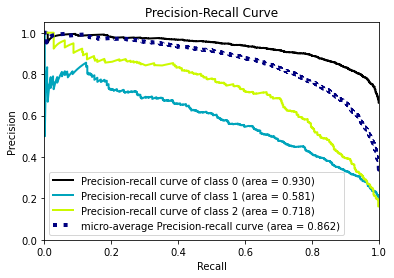

91/91 [==============================] - 0s 2ms/step - loss: 0.5472 - accuracy: 0.7761
Epoch 1/100
288/288 [==============================] - 4s 9ms/step - loss: 0.9065 - accuracy: 0.6214 - val_loss: 0.5569 - val_accuracy: 0.8039
Epoch 2/100
288/288 [==============================] - 2s 7ms/step - loss: 0.5726 - accuracy: 0.7687 - val_loss: 0.4656 - val_accuracy: 0.8269
Epoch 3/100
288/288 [==============================] - 2s 7ms/step - loss: 0.3885 - accuracy: 0.8736 - val_loss: 0.4404 - val_accuracy: 0.8247
Epoch 4/100
288/288 [==============================] - 2s 7ms/step - loss: 0.2920 - accuracy: 0.9067 - val_loss: 0.4500 - val_accuracy: 0.8195
Epoch 5/100
288/288 [==============================] - 2s 7ms/step - loss: 0.2159 - accuracy: 0.9326 - val_loss: 0.4800 - val_accuracy: 0.8126
Epoch 6/100
288/288 [==============================] - 2s 7ms/step - loss: 0.1558 - accuracy: 0.9519 - val_loss: 0.5022 - val_accuracy: 0.8074
Restoring model weights from the end of the best epoch.

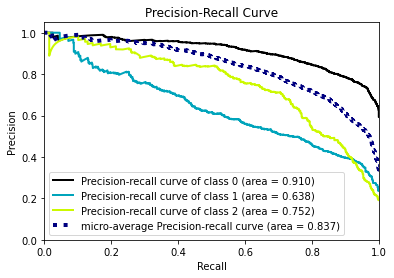

91/91 [==============================] - 0s 1ms/step - loss: 0.6035 - accuracy: 0.7459
Epoch 1/100
289/289 [==============================] - 5s 11ms/step - loss: 0.8673 - accuracy: 0.6709 - val_loss: 0.5466 - val_accuracy: 0.8035
Epoch 2/100
289/289 [==============================] - 3s 9ms/step - loss: 0.5609 - accuracy: 0.7703 - val_loss: 0.4570 - val_accuracy: 0.8278
Epoch 3/100
289/289 [==============================] - 3s 9ms/step - loss: 0.3810 - accuracy: 0.8720 - val_loss: 0.4461 - val_accuracy: 0.8317
Epoch 4/100
289/289 [==============================] - 87s 301ms/step - loss: 0.2836 - accuracy: 0.9111 - val_loss: 0.4526 - val_accuracy: 0.8308
Epoch 5/100
289/289 [==============================] - 3s 11ms/step - loss: 0.2059 - accuracy: 0.9355 - val_loss: 0.4828 - val_accuracy: 0.8230
Epoch 6/100
289/289 [==============================] - 3s 11ms/step - loss: 0.1551 - accuracy: 0.9539 - val_loss: 0.5067 - val_accuracy: 0.8169
Restoring model weights from the end of the best 

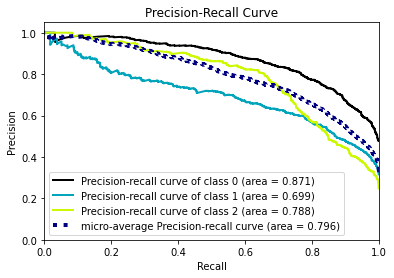

90/90 [==============================] - 1s 4ms/step - loss: 0.6788 - accuracy: 0.7208
Epoch 1/100
289/289 [==============================] - 5s 12ms/step - loss: 0.9408 - accuracy: 0.5831 - val_loss: 0.5560 - val_accuracy: 0.7974
Epoch 2/100
289/289 [==============================] - 4s 13ms/step - loss: 0.6122 - accuracy: 0.7515 - val_loss: 0.4576 - val_accuracy: 0.8312
Epoch 3/100
289/289 [==============================] - 3s 11ms/step - loss: 0.4336 - accuracy: 0.8500 - val_loss: 0.4415 - val_accuracy: 0.8291
Epoch 4/100
289/289 [==============================] - 3s 11ms/step - loss: 0.3185 - accuracy: 0.8926 - val_loss: 0.4601 - val_accuracy: 0.8143
Epoch 5/100
289/289 [==============================] - 3s 11ms/step - loss: 0.2429 - accuracy: 0.9235 - val_loss: 0.4645 - val_accuracy: 0.8148
Epoch 6/100
289/289 [==============================] - 3s 11ms/step - loss: 0.1850 - accuracy: 0.9518 - val_loss: 0.4795 - val_accuracy: 0.8161
Restoring model weights from the end of the best 

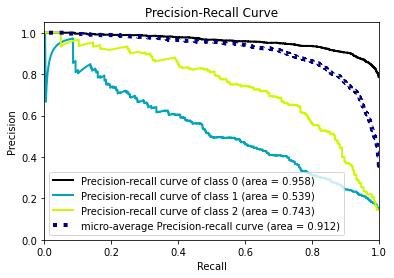

90/90 [==============================] - 1s 2ms/step - loss: 0.4328 - accuracy: 0.8372
Epoch 1/100
289/289 [==============================] - 5s 12ms/step - loss: 0.9460 - accuracy: 0.5728 - val_loss: 0.5085 - val_accuracy: 0.8169
Epoch 2/100
289/289 [==============================] - 3s 10ms/step - loss: 0.6138 - accuracy: 0.7510 - val_loss: 0.4241 - val_accuracy: 0.8408
Epoch 3/100
289/289 [==============================] - 3s 10ms/step - loss: 0.4348 - accuracy: 0.8430 - val_loss: 0.3949 - val_accuracy: 0.8486
Epoch 4/100
289/289 [==============================] - 3s 10ms/step - loss: 0.3261 - accuracy: 0.8943 - val_loss: 0.4031 - val_accuracy: 0.8399
Epoch 5/100
289/289 [==============================] - 3s 10ms/step - loss: 0.2401 - accuracy: 0.9220 - val_loss: 0.4201 - val_accuracy: 0.8356
Epoch 6/100
289/289 [==============================] - 3s 10ms/step - loss: 0.1781 - accuracy: 0.9432 - val_loss: 0.4519 - val_accuracy: 0.8347
Restoring model weights from the end of the best 

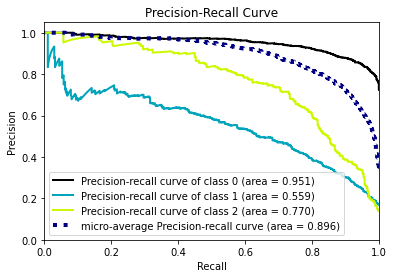

90/90 [==============================] - 1s 2ms/step - loss: 0.4768 - accuracy: 0.8097


In [11]:
tokenizer = Tokenizer(num_words=len(unique))
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)
word_index = tokenizer.word_index

model_inputs = pad_sequences(sequences, maxlen=max_length, padding='post')
kf = KFold(n_splits = 5)
embedding_dim = 32

RNN_accuracy = []

for train_index, test_index in kf.split(model_inputs, labels): #Tests the model with 5 splits
    x_train, x_test, y_train, y_test = model_inputs[train_index], model_inputs[test_index], \
                                       labels[train_index], labels[test_index]

    inputs = tf.keras.Input(shape=(max_length,))

    embedding = tf.keras.layers.Embedding(
        input_dim=len(unique),
        output_dim=embedding_dim,
        input_length=max_length
    )(inputs)
   
    flatten = tf.keras.layers.Flatten()(embedding)    # Flatten layer
    gru = tf.keras.layers.GRU(units=embedding_dim)(embedding)   # GRU with a Flatten layer
    gru_flatten = tf.keras.layers.Flatten()(gru)
    concat = tf.keras.layers.concatenate([flatten, gru_flatten])  # Both are fed into the output
    outputs = tf.keras.layers.Dense(3, activation='softmax')(concat)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        x_train,
        y_train,
        validation_split=0.2,
        batch_size=32,
        epochs=100,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=3,
                restore_best_weights=True,
                verbose=1
            ),
            tf.keras.callbacks.ReduceLROnPlateau()
        ]
    )
    skplt.metrics.plot_precision_recall(y_test, model.predict(x_test))
    plt.show()
    RNN_accuracy.append(model.evaluate(x_test, y_test))
    

In [33]:
accuracy = [x[1] for x in RNN_accuracy]
average = sum(accuracy)/len(accuracy)
rounded_percentage = round(average*100, 1)
print("Average Accuracy:", f"{rounded_percentage}%")

Average Accuracy: 77.8%


# Naive Bayes

Average Accuracy 73.6%


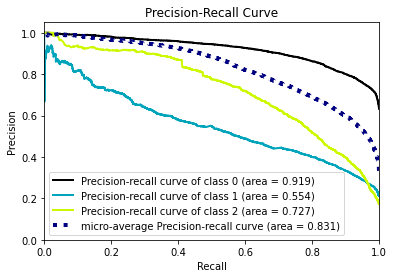

In [37]:
vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
joined_tweets = [' '.join(tweet) for tweet in tweets]
processed_features = vectorizer.fit_transform(joined_tweets)

predict_proba = cross_val_predict(MultinomialNB() ,processed_features, labels, method='predict_proba')
skplt.metrics.plot_precision_recall(labels, predict_proba)

average = sum(cross_val_score(MultinomialNB(), processed_features, labels))/5
rounded_percentage = round(average*100, 1)
print("Average Accuracy", f"{rounded_percentage}%")

# Support Vector Machines

Average Accuracy 77.4%


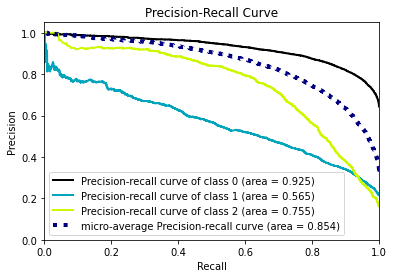

In [38]:
predict_proba = cross_val_predict(LinearSVC(), processed_features, labels, method='_predict_proba_lr')
skplt.metrics.plot_precision_recall(labels, predict_proba)

average = sum(cross_val_score(LinearSVC(), processed_features, labels))/5
rounded_percentage = round(average*100, 1)
print("Average Accuracy", f"{rounded_percentage}%")
